In [5]:
import os
import sys
import psutil

import pandas as pd
import numpy as np

import keras
import random

from keras.models import Sequential,Model
from keras.layers import Dense,LSTM,Activation,Dropout,BatchNormalization,Input,Embedding
from keras.layers import Flatten,Conv2D,MaxPooling2D,Bidirectional,concatenate

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
import keras_metrics as km

import matplotlib
import matplotlib.pyplot as plt
import math
from multiprocessing import cpu_count,Pool 
import multiprocessing


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import roc_curve, auc

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from keras_self_attention import SeqSelfAttention

from utils import *
from base import *

In [3]:
SEQ=8
verbose = 2
dropout=0.3
ACT_POSTERIOR = 'relu'
weights = np.array([0.2,0.8])
patience = 10
weight_decay = 0.0001
lr=0.1
lr_decay=1e-6

LSTM_UNIT = 128
GEOHASH_UNIT = 32
EMBEDDING_UNIT = 128
NLP_UNIT = 128
SEQ_UNIT = 256
ACT_PRIOR = 'sigmoid'
DENSE_CONCAT = 256
VAL_SPLIT = 0.2
CONV_UNIT = 32
ADD_ON_LAYERS = True
Embedding_outdim = 100

In [9]:
class model_LSTM_aug_embed(keras_model):
    
    def load_data(self):
        super(model_LSTM_aug_embed,self).load_data(with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        print (self.X_train2.shape)
        print (self.X_train3.shape)
        print (self.X_train4.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1)(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm,geohash_vec,nlp_vec,embeding])
        
        main_output = self.last_layers(level_3)
        
        self.model = Model(inputs=[input1,input2,input3,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train2,self.X_train3,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test2,self.X_test3,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)
        
        


In [11]:

    
def compare_models(city='Atlanta',vr=2,drop=0.2,val_split=0.2,p=15,w_d=0,LR=0.01,lr_dc=1e-6,
                   add_on_layer=True,
                   w=[1,4],
                   act_prior = 'sigmoid',act_posterior='relu',
                   lstm_unit=128,geohash_unit=128,embedding_unit=128,nlp_unit=128,seq_unit=256,
                   dense_concat=512,conv_unit=32,
                  ):

    #global SEQ=8
    global verbose
    global dropout
    global ACT_POSTERIOR
    global ACT_PRIOR
    global weights
    global patience
    global weight_decay
    global lr
    global lr_decay
    
    global GEOHASH_UNIT
    global EMBEDDING_UNIT 
    global NLP_UNIT
    global SEQ_UNIT
    
    global LSTM_UNIT
    global DENSE_CONCAT
    global CONV_UNIT
    global ADD_ON_LAYER
    global VAL_SPLIT
    global Embedding_outdim
    verbose = vr
    dropout=drop
    weights = np.array(w)
    patience = p
    weight_decay = w_d
    lr=LR
    lr_decay=lr_dc
    
    ACT_PRIOR = act_prior
    ACT_POSTERIOR = act_posterior
    
    LSTM_UNIT = lstm_unit
    GEOHASH_UNIT = geohash_unit
    EMBEDDING_UNIT = embedding_unit
    NLP_UNIT = nlp_unit
    SEQ_UNIT = seq_unit
    DENSE_CONCAT = dense_concat
    CONV_UNIT = conv_unit
    Embedding_outdim = embedding_unit
    
    ADD_ON_LAYER = add_on_layer
    VAL_SPLIT = val_split
    def initialte_class(classname):
        if classname=='DNN':
            mypred = DNN(city=city)
            return mypred
        if classname=='DNN_embed':
            mypred = DNN_embed(city=city)
            return mypred
        if classname=='RNN':
            mypred = model_LSTM_aug(city=city)
            return mypred
        if classname=='RNN_embed':
            mypred = model_LSTM_aug_embed(city=city)
            return mypred
        if classname=='ATT':
            mypred = model_LSTM_aug_embed_att(city=city)
            return mypred
        print ('error in name')
        raise
        return None        
    def do_rest(pred):
        pred.load_data()
        pred.create_model()
        pred.compile_model()
        pred.train()
        return pred
    
    def process_frame(df,i):
        new_df = df[['0','1','weighted avg','micro avg','macro avg']].drop('support',axis=0)
        new_df=new_df.stack().swaplevel()
        new_df.index=new_df.index.map('{0[0]}_{0[1]}'.format) 
        new_df = new_df.to_frame().T
        new_df['run'] = i
        new_df = new_df.set_index('run')
        return new_df
    def rerun(classname):
        df_list=[]
        for i in range(3):
            print ("*"*20,classname,"*"*20)
            print ('*'*10,' round ', i)
            mypred = initialte_class(classname)
            mypred = do_rest(mypred)
            res  = mypred.evaluate()
            df_list.append(process_frame(res,i))
        df = pd.concat(df_list)
        return pd.DataFrame(df.mean(),columns=[classname])
    
    return rerun('RNN_embed')
        
    

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 314)
(12085, 2)
(2515, 314)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)         

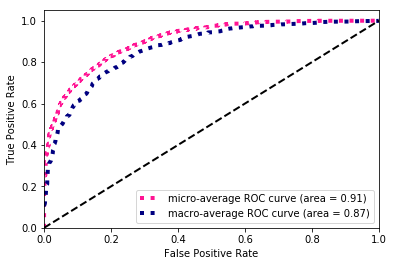

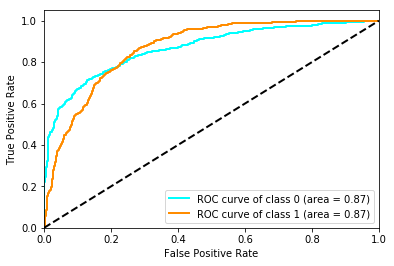

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.879565    0.602224     0.740895     0.815109      0.821009
precision     0.904635    0.551724     0.728180     0.815109      0.830124
recall        0.855847    0.662900     0.759373     0.815109      0.815109
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.867607    0.867607     0.868071     0.905844           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 314)
(12085, 2)
(2515, 314)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)         

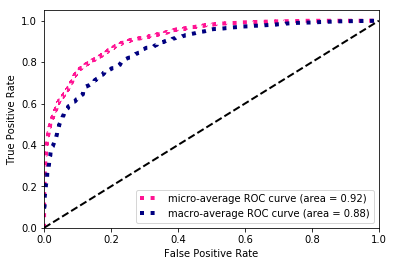

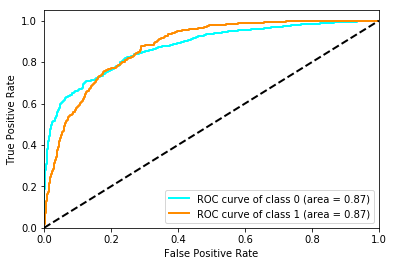

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.892920    0.599434     0.746177     0.831014      0.830956
precision     0.892695    0.600000     0.746348     0.831014      0.830898
recall        0.893145    0.598870     0.746008     0.831014      0.831014
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.874637    0.874637     0.875067     0.919151           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 314)
(12085, 2)
(2515, 314)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)         

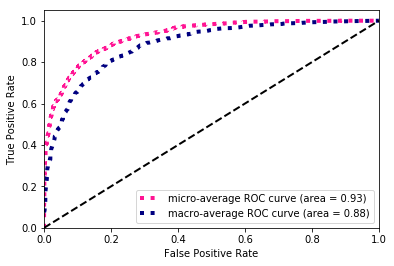

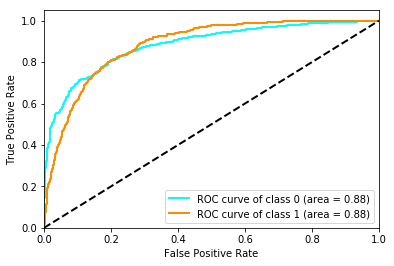

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.904515    0.603889     0.754202     0.846123      0.841043
precision     0.885935    0.661435     0.773685     0.846123      0.838536
recall        0.923891    0.555556     0.739723     0.846123      0.846123
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.883348    0.883348     0.883793     0.927577           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 314)
(12085, 2)
(2515, 314)
(2515, 2)
(12085, 8, 25)
(12085, 14)
(12085, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

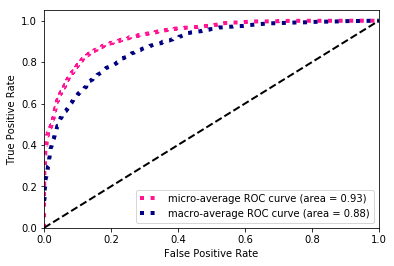

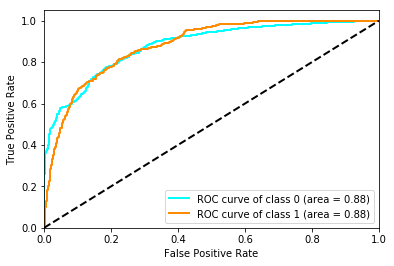

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.908097    0.631474     0.769786     0.852883      0.849693
precision     0.895201    0.670190     0.782696     0.852883      0.847694
recall        0.921371    0.596987     0.759179     0.852883      0.852883
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.880807    0.880807     0.881230     0.928682           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 314)
(12085, 2)
(2515, 314)
(2515, 2)
(12085, 8, 25)
(12085, 14)
(12085, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

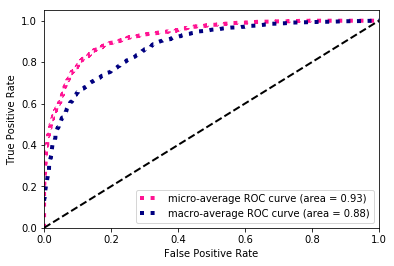

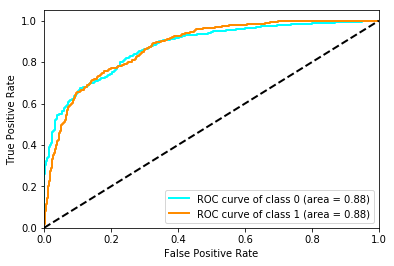

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.909315    0.621399     0.765357     0.853678      0.848526
precision     0.889585    0.684807     0.787196     0.853678      0.846350
recall        0.929940    0.568738     0.749339     0.853678      0.853678
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.875650    0.875650     0.876095     0.926368           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 314)
(12085, 2)
(2515, 314)
(2515, 2)
(12085, 8, 25)
(12085, 14)
(12085, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

Epoch 43/60
 - 2s - loss: 0.2689 - f1_score: 0.6448 - val_loss: 0.3478 - val_f1_score: 0.4164
Epoch 44/60
 - 2s - loss: 0.2691 - f1_score: 0.6551 - val_loss: 0.8289 - val_f1_score: 0.0000e+00
Epoch 45/60
 - 2s - loss: 0.2650 - f1_score: 0.6469 - val_loss: 0.5344 - val_f1_score: 0.0475
Epoch 46/60
 - 2s - loss: 0.2661 - f1_score: 0.6496 - val_loss: 0.4043 - val_f1_score: 0.5436
Epoch 47/60
 - 2s - loss: 0.2659 - f1_score: 0.6534 - val_loss: 1.0294 - val_f1_score: 0.0000e+00


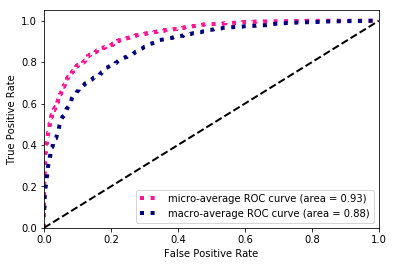

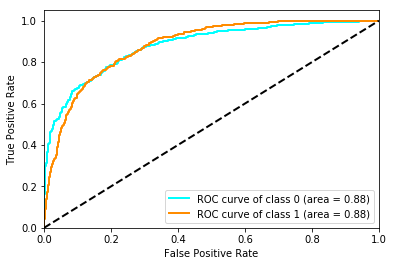

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.906615    0.581699     0.744157     0.847316      0.838014
precision     0.875940    0.689922     0.782931     0.847316      0.836665
recall        0.939516    0.502825     0.721170     0.847316      0.847316
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.880283    0.880283     0.880720     0.928606           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 315)
(12085, 2)
(2515, 315)
(2515, 2)
(12085, 8, 25)
(12085, 14)
(12085, 100)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

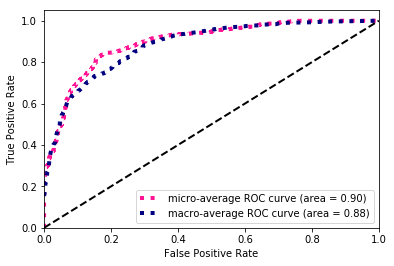

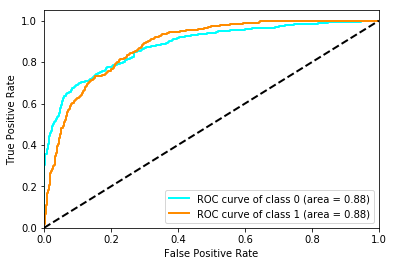

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.889523    0.637138     0.763330     0.830616      0.836236
precision     0.916132    0.581649     0.748891     0.830616      0.845512
recall        0.864415    0.704331     0.784373     0.830616      0.830616
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.881182    0.881182     0.881617     0.895041           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(12085, 315)
(12085, 2)
(2515, 315)
(2515, 2)
(12085, 8, 25)
(12085, 14)
(12085, 100)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

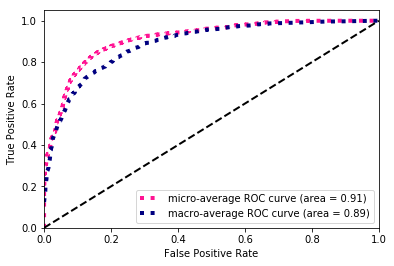

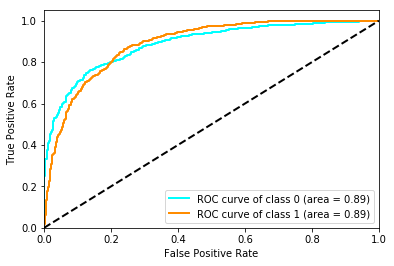

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.899975    0.643052     0.771513     0.843738      0.845730
precision     0.908997    0.621053     0.765025     0.843738      0.848203
recall        0.891129    0.666667     0.778898     0.843738      0.843738
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.887923    0.887923     0.888381     0.913299           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(12085, 315)
(12085, 2)
(2515, 315)
(2515, 2)
(12085, 8, 25)
(12085, 14)
(12085, 100)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

 - 2s - loss: 0.2755 - f1_score: 0.6309 - val_loss: 0.3737 - val_f1_score: 0.4196
Epoch 34/60
 - 2s - loss: 0.2783 - f1_score: 0.6367 - val_loss: 0.3464 - val_f1_score: 0.3935


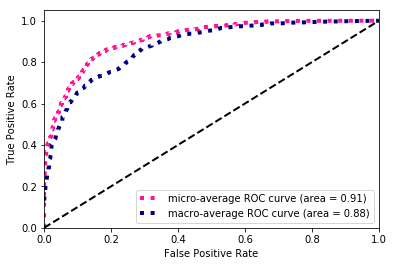

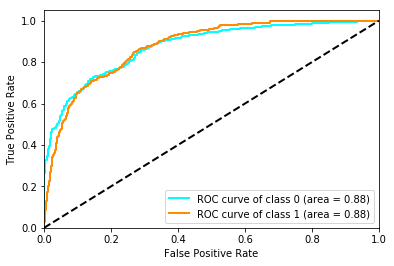

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.895438    0.638298     0.766868     0.837773      0.841147
precision     0.910845    0.603015     0.756930     0.837773      0.845852
recall        0.880544    0.677966     0.779255     0.837773      0.837773
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.876421    0.876421     0.876868     0.912959           NaN

In [13]:
Atlanta = compare_models(w=[1,1])

In [14]:
Atlanta

DNN       RNN  RNN_embed
0_f1-score              0.892333  0.908009   0.894979
1_f1-score              0.601849  0.611524   0.639496
weighted avg_f1-score   0.831003  0.845411   0.841038
micro avg_f1-score      0.830749  0.851292   0.837376
macro avg_f1-score      0.747091  0.759767   0.767237
0_precision             0.894422  0.886909   0.911992
1_precision             0.604386  0.681640   0.601905
weighted avg_precision  0.833186  0.843570   0.846522
micro avg_precision     0.830749  0.851292   0.837376
macro avg_precision     0.749404  0.784274   0.756948
0_recall                0.890961  0.930276   0.878696
1_recall                0.605775  0.556183   0.682988
weighted avg_recall     0.830749  0.851292   0.837376
micro avg_recall        0.830749  0.851292   0.837376
macro avg_recall        0.748368  0.743229   0.780842
0_auc                   0.875197  0.878914   0.881842
1_auc                   0.875197  0.878914   0.881842
micro avg_auc           0.917524  0.927885   0.907100
macro avg_auc           0.875644  0.879348   0.882289

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 512)               161280    
_________________________________________________________________
dense_53 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)         

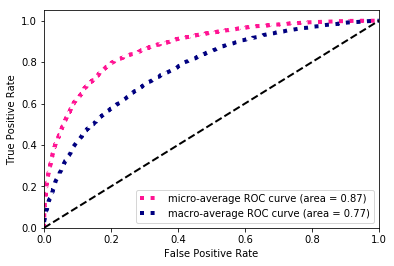

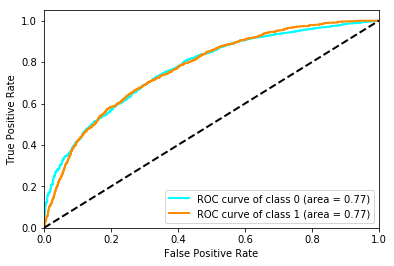

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.875740     0.459660     0.667700     0.797945      0.785019
precision     0.843509     0.551255     0.697382     0.797945      0.779787
recall        0.910532     0.394166     0.652349     0.797945      0.797945
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.769605     0.769605     0.769819     0.871829           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 512)               161280    
_________________________________________________________________
dense_57 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
activation_21 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)         

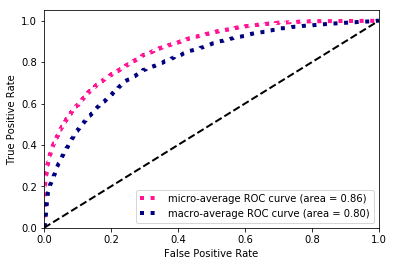

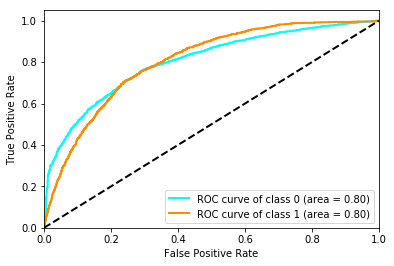

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.846595     0.531880     0.689237     0.768917      0.777976
precision     0.880234     0.476331     0.678283     0.768917      0.792169
recall        0.815433     0.602094     0.708763     0.768917      0.768917
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.803800     0.803800     0.804008     0.863314           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 512)               161280    
_________________________________________________________________
dense_61 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
activation_23 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)         

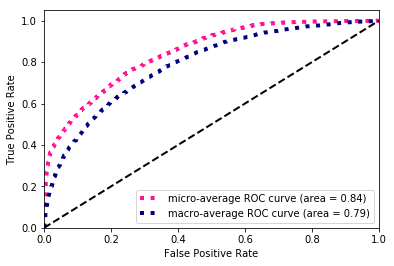

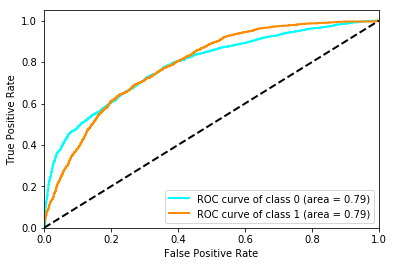

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.831068     0.524121     0.677595     0.750652      0.764143
precision     0.883694     0.448827     0.666260     0.750652      0.788877
recall        0.784359     0.629768     0.707063     0.750652      0.750652
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.786121     0.786123     0.786328     0.844119           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

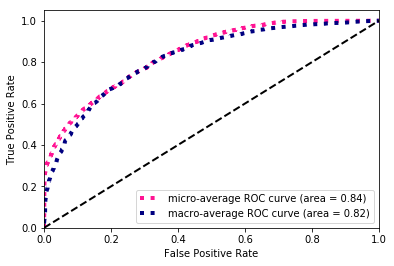

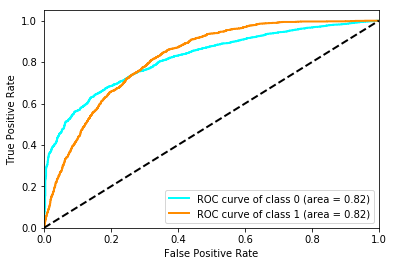

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.814294     0.551128     0.682711     0.737280      0.756914
precision     0.910309     0.439165     0.674737     0.737280      0.807583
recall        0.736601     0.739716     0.738158     0.737280      0.737280
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.820249     0.820249     0.820451     0.839864           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

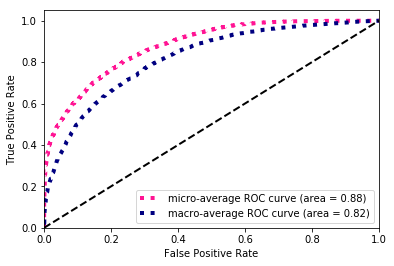

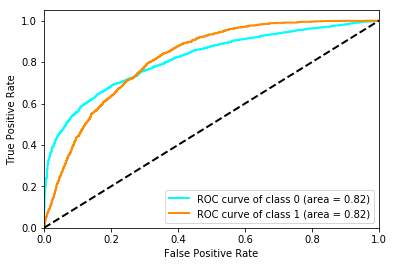

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.856838     0.535640     0.696239     0.781148      0.786805
precision     0.877047     0.498390     0.687719     0.781148      0.794486
recall        0.837539     0.578908     0.708224     0.781148      0.781148
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.816792     0.816792     0.816995     0.877985           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_17 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

Epoch 43/60
 - 4s - loss: 0.4055 - f1_score: 0.4681 - val_loss: 0.3308 - val_f1_score: 0.4233
Epoch 44/60
 - 4s - loss: 0.4045 - f1_score: 0.4590 - val_loss: 0.3202 - val_f1_score: 0.2752


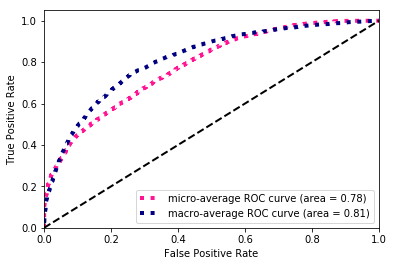

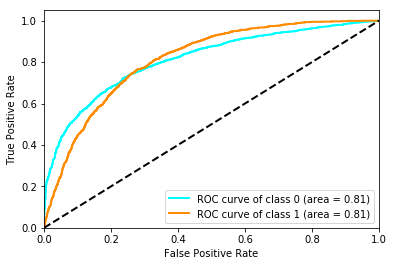

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.765053     0.536597     0.650825     0.688193      0.715241
precision     0.931200     0.396916     0.664058     0.688193      0.814706
recall        0.649218     0.827973     0.738596     0.688193      0.688193
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.813085     0.813085     0.813283     0.780575           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

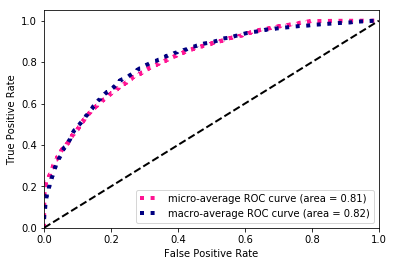

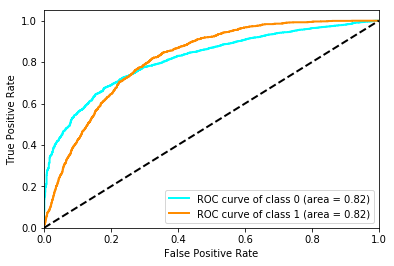

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.806640     0.554178     0.680409     0.730267      0.751594
precision     0.917797     0.433207     0.675502     0.730267      0.812139
recall        0.719499     0.768886     0.744193     0.730267      0.730267
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.816315     0.816315     0.816509     0.814744           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

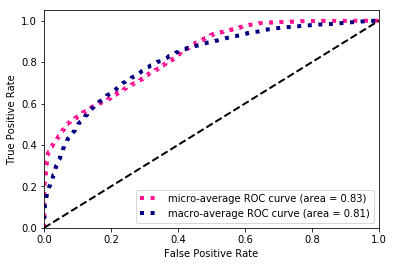

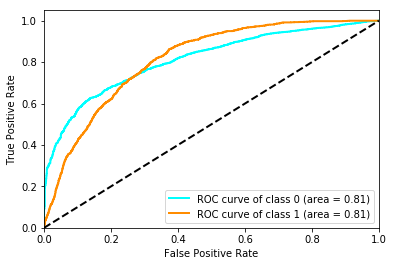

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.791415     0.540851     0.666133     0.713144      0.736783
precision     0.917262     0.415397     0.666330     0.713144      0.807837
recall        0.695933     0.774869     0.735401     0.713144      0.713144
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.812940     0.812940     0.813132     0.830522           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

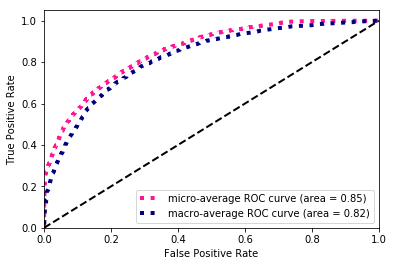

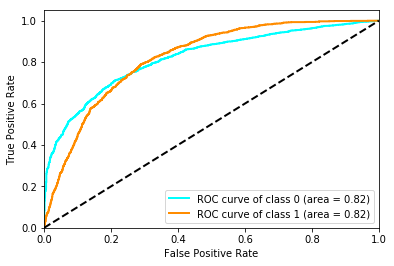

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.835276     0.559880     0.697578     0.760274      0.775229
precision     0.902640     0.466800     0.684720     0.760274      0.807611
recall        0.777268     0.699327     0.738297     0.760274      0.760274
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.820826     0.820826     0.821028     0.853439           NaN

In [15]:
LosAngeles =compare_models('LosAngeles',w=[1,1])

In [16]:
LosAngeles

DNN       RNN  RNN_embed
0_f1-score              0.851134  0.812062   0.811110
1_f1-score              0.505220  0.541122   0.551636
weighted avg_f1-score   0.775712  0.752987   0.754535
micro avg_f1-score      0.772505  0.735540   0.734562
macro avg_f1-score      0.678177  0.676592   0.681373
0_precision             0.869145  0.906185   0.912566
1_precision             0.492138  0.444824   0.438468
weighted avg_precision  0.786944  0.805592   0.809196
micro avg_precision     0.772505  0.735540   0.734562
macro avg_precision     0.680642  0.675505   0.675517
0_recall                0.836774  0.741119   0.730900
1_recall                0.542009  0.715532   0.747694
weighted avg_recall     0.772505  0.735540   0.734562
micro avg_recall        0.772505  0.735540   0.734562
macro avg_recall        0.689392  0.728326   0.739297
0_auc                   0.786509  0.816708   0.816694
1_auc                   0.786509  0.816708   0.816694
micro avg_auc           0.859754  0.832808   0.832901
macro avg_auc           0.786718  0.816910   0.816890

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_104 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_37 (Batc (None, 256)               1024      
_________________________________________________________________
activation_37 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)         

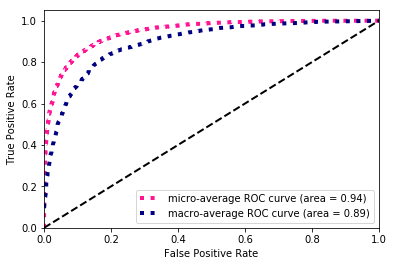

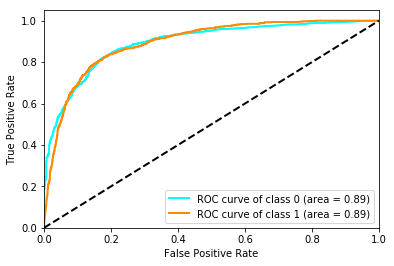

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.919585    0.640469     0.780027     0.868568      0.871650
precision     0.932181    0.603982     0.768082     0.868568      0.875816
recall        0.907326    0.681648     0.794487     0.868568      0.868568
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.893590    0.893590     0.893854     0.944798           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_108 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_39 (Batc (None, 256)               1024      
_________________________________________________________________
activation_39 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)         

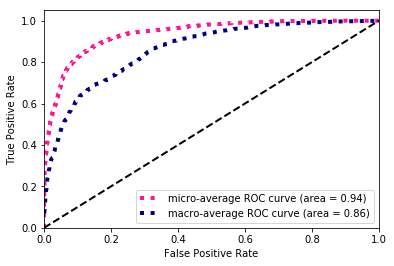

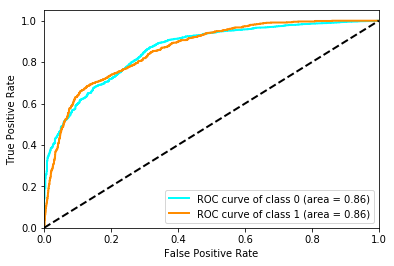

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.920438    0.501558     0.710998     0.862779      0.848499
precision     0.885434    0.666667     0.776050     0.862779      0.847863
recall        0.958323    0.401998     0.680160     0.862779      0.862779
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.860949    0.860949     0.861224     0.936559           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_112 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_41 (Batc (None, 256)               1024      
_________________________________________________________________
activation_41 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)         

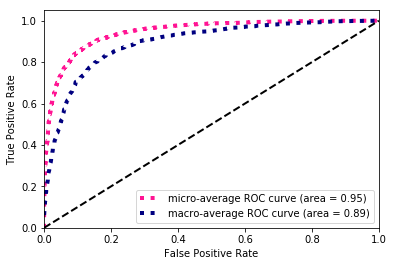

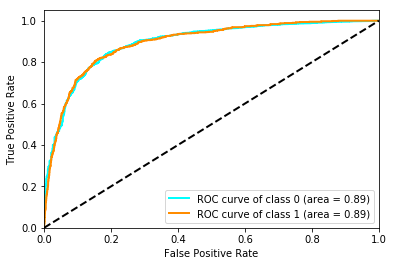

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.925288    0.640498     0.782893     0.876286      0.876378
precision     0.925648    0.639303     0.782476     0.876286      0.876471
recall        0.924929    0.641698     0.783313     0.876286      0.876286
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.893078    0.893078     0.893350     0.945347           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

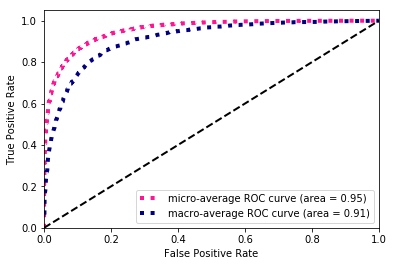

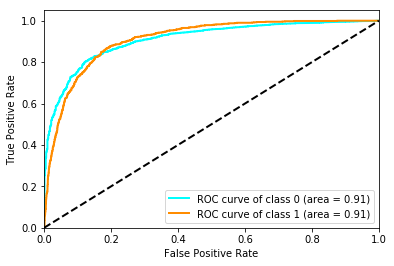

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.928798    0.612836     0.770817     0.879717      0.874535
precision     0.911106    0.685185     0.798145     0.879717      0.872306
recall        0.947191    0.554307     0.750749     0.879717      0.879717
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.909669    0.909669     0.909929     0.954720           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_27 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

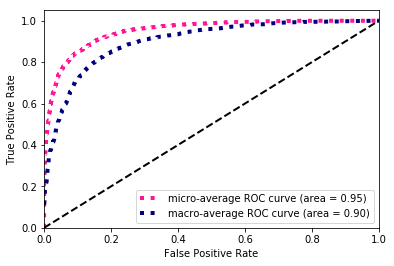

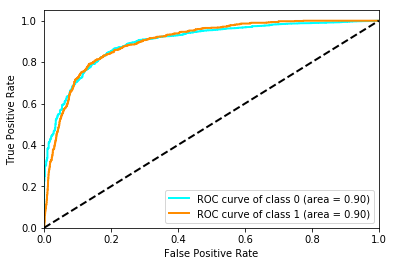

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.924589    0.634941     0.779765     0.875000      0.874845
precision     0.923992    0.636935     0.780463     0.875000      0.874692
recall        0.925188    0.632959     0.779073     0.875000      0.875000
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.899719    0.899719     0.899973     0.949435           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

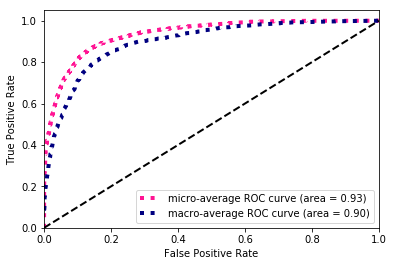

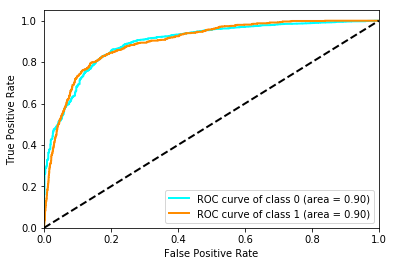

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.915865    0.657609     0.786737     0.864923      0.871512
precision     0.945931    0.582291     0.764111     0.864923      0.883479
recall        0.887652    0.755306     0.821479     0.864923      0.864923
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.896565    0.896565     0.896825     0.934935           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

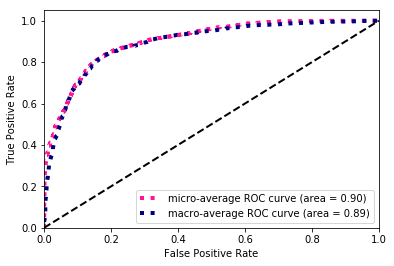

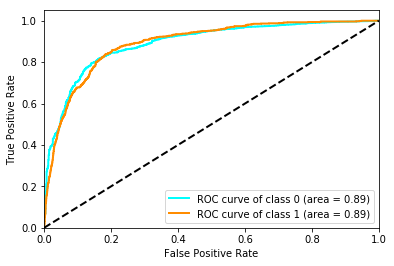

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.885921    0.616822     0.751372     0.824185      0.839706
precision     0.957594    0.492905     0.725250     0.824185      0.877788
recall        0.824230    0.823970     0.824100     0.824185      0.824185
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.891171    0.891171     0.891427     0.901421           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

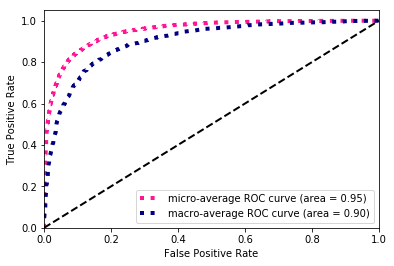

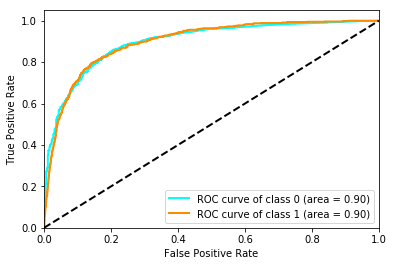

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.925319    0.650426     0.787873     0.876930      0.878108
precision     0.930160    0.634958     0.782559     0.876930      0.879461
recall        0.920528    0.666667     0.793597     0.876930      0.876930
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.898326    0.898326     0.898595     0.948686           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

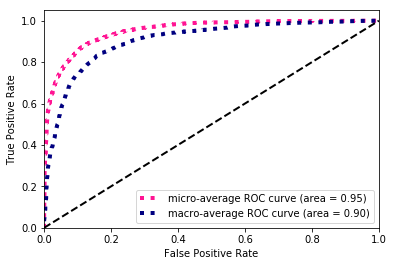

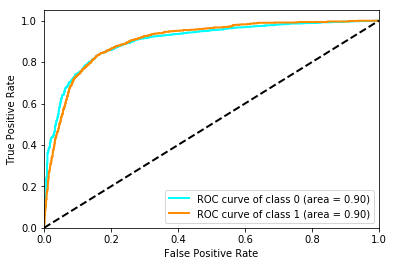

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.927502    0.661398     0.794450     0.880575      0.881801
precision     0.932723    0.644550     0.788636     0.880575      0.883231
recall        0.922340    0.679151     0.800746     0.880575      0.880575
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.904289    0.904289     0.904557     0.951202           NaN

In [17]:
Austin =compare_models('Austin',w=[1,1])

In [18]:
Austin

DNN       RNN  RNN_embed
0_f1-score              0.921770  0.923084   0.912914
1_f1-score              0.594175  0.635129   0.642882
weighted avg_f1-score   0.865509  0.873630   0.866538
micro avg_f1-score      0.869211  0.873213   0.860563
macro avg_f1-score      0.757973  0.779106   0.777898
0_precision             0.914421  0.927009   0.940159
1_precision             0.636651  0.634804   0.590804
weighted avg_precision  0.866716  0.876826   0.880160
micro avg_precision     0.869211  0.873213   0.860563
macro avg_precision     0.775536  0.780906   0.765482
0_recall                0.930192  0.920010   0.889033
1_recall                0.575114  0.647524   0.723263
weighted avg_recall     0.869211  0.873213   0.860563
micro avg_recall        0.869211  0.873213   0.860563
macro avg_recall        0.752653  0.783767   0.806148
0_auc                   0.882539  0.901984   0.897929
1_auc                   0.882539  0.901984   0.897929
micro avg_auc           0.942235  0.946364   0.933769
macro avg_auc           0.882809  0.902242   0.898193

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_154 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_155 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_55 (Batc (None, 256)               1024      
_________________________________________________________________
activation_55 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)           

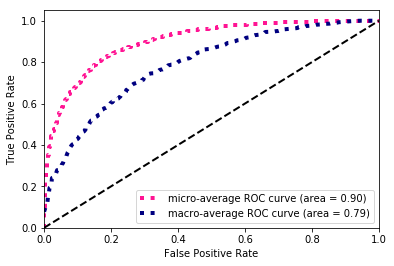

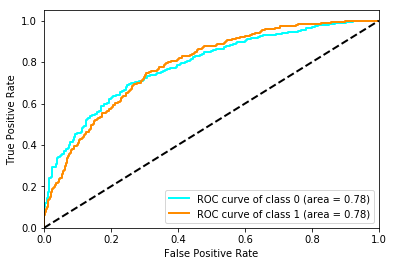

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.892015    0.422764     0.657390     0.818065      0.814759
precision     0.884615    0.442553     0.663584     0.818065      0.811835
recall        0.899540    0.404669     0.652105     0.818065      0.818065
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.784793    0.784793     0.785772     0.900119           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_159 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_57 (Batc (None, 256)               1024      
_________________________________________________________________
activation_57 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)           

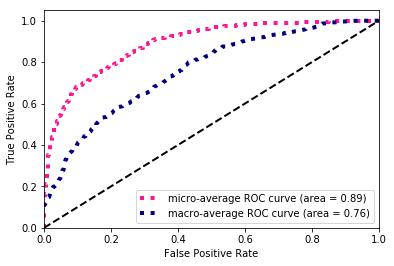

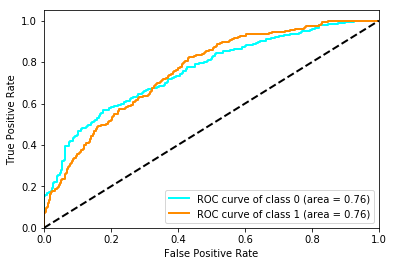

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.873010    0.402194     0.637602     0.790519      0.795495
precision     0.884343    0.379310     0.631827     0.790519      0.801195
recall        0.861963    0.428016     0.644989     0.790519      0.790519
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.757570    0.757570     0.758625     0.888638           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_163 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_59 (Batc (None, 256)               1024      
_________________________________________________________________
activation_59 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)           

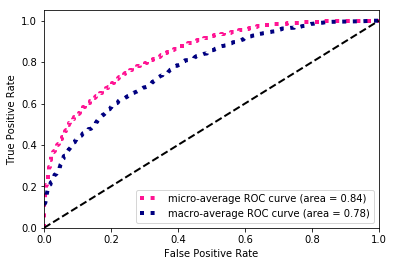

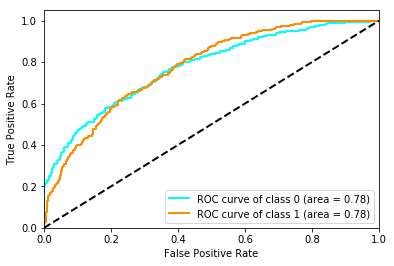

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.839109    0.441261     0.640185     0.750160      0.773608
precision     0.908036    0.349206     0.628621     0.750160      0.816031
recall        0.779908    0.599222     0.689565     0.750160      0.750160
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.776369    0.776369     0.777290     0.841688           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input (Inp

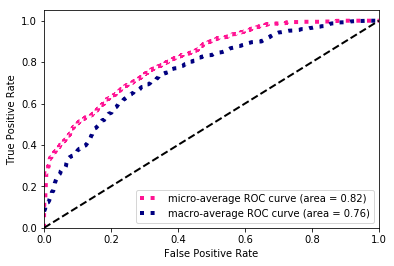

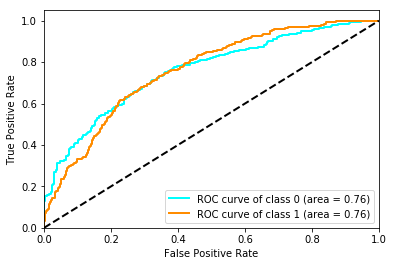

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.812606    0.431525     0.622066     0.718129      0.749866
precision     0.913793    0.323017     0.618405     0.718129      0.816529
recall        0.731595    0.649805     0.690700     0.718129      0.718129
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.757973    0.757973     0.759001     0.817470           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_39 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input (Inp

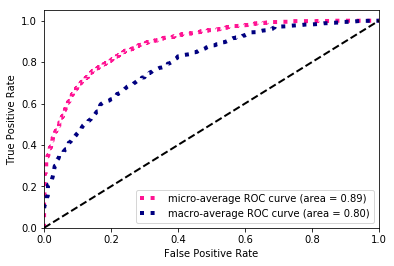

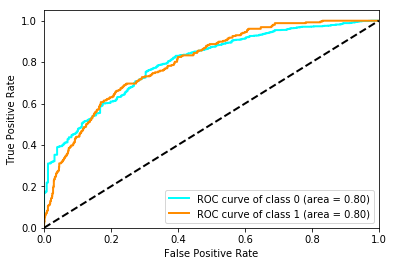

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.880345    0.467714     0.674030     0.804612      0.812410
precision     0.901205    0.424051     0.662628     0.804612      0.822647
recall        0.860429    0.521401     0.690915     0.804612      0.804612
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.798565    0.798565     0.799430     0.892025           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_41 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input (Inp

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


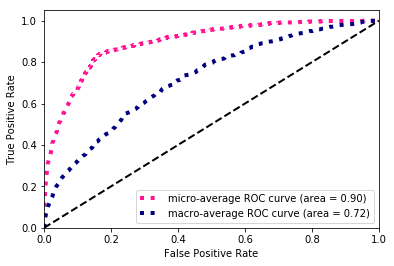

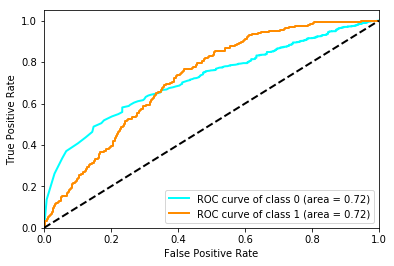

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.455148     0.835362      0.760427
precision     0.835362    0.000000     0.417681     0.835362      0.697830
recall        1.000000    0.000000     0.500000     0.835362      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.716959    0.717198     0.717917     0.895073           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________


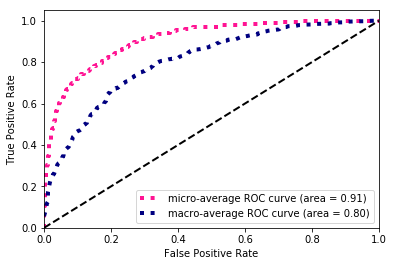

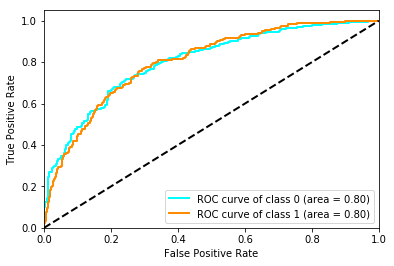

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.886997    0.457249     0.672123     0.812940      0.816244
precision     0.895312    0.437722     0.666517     0.812940      0.819976
recall        0.878834    0.478599     0.678717     0.812940      0.812940
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.802660    0.802660     0.803653     0.906976           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________


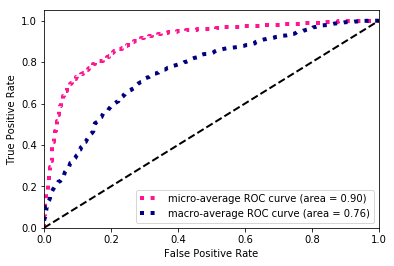

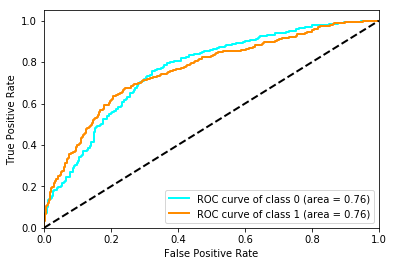

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.891420    0.413934     0.652677     0.816784      0.812808
precision     0.882707    0.437229     0.659968     0.816784      0.809364
recall        0.900307    0.392996     0.646651     0.816784      0.816784
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.761602    0.761602     0.762722     0.900145           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________


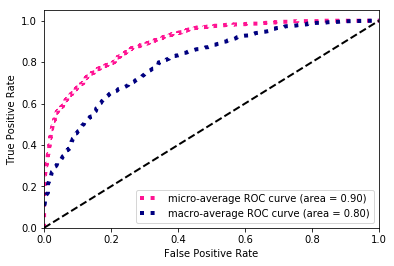

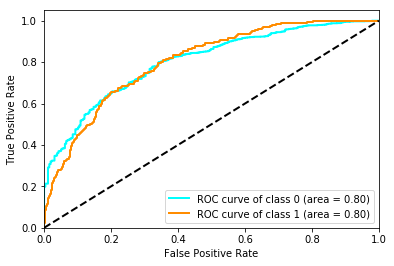

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.874408    0.461017     0.667712     0.796284      0.806348
precision     0.901466    0.408408     0.654937     0.796284      0.820290
recall        0.848926    0.529183     0.689055     0.796284      0.796284
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.803656    0.803654     0.804526     0.897663           NaN

In [19]:
Miami =compare_models('Miami',w=[1,1])

In [20]:
Miami

DNN       RNN  RNN_embed
0_f1-score              0.868045  0.867749   0.884275
1_f1-score              0.422073  0.299746   0.444067
weighted avg_f1-score   0.794621  0.774234   0.811800
micro avg_f1-score      0.786248  0.786035   0.808670
macro avg_f1-score      0.645059  0.583748   0.664171
0_precision             0.892331  0.883453   0.893162
1_precision             0.390357  0.249023   0.427787
weighted avg_precision  0.809687  0.779002   0.816543
micro avg_precision     0.786248  0.786035   0.808670
macro avg_precision     0.641344  0.566238   0.660474
0_recall                0.847137  0.864008   0.876022
1_recall                0.477302  0.390402   0.466926
weighted avg_recall     0.786248  0.786035   0.808670
micro avg_recall        0.786248  0.786035   0.808670
macro avg_recall        0.662220  0.627205   0.671474
0_auc                   0.772911  0.757832   0.789306
1_auc                   0.772911  0.757912   0.789305
micro avg_auc           0.876815  0.868189   0.901595
macro avg_auc           0.773896  0.758783   0.790300

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_206 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
activation_73 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)         

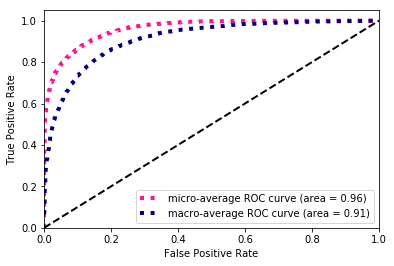

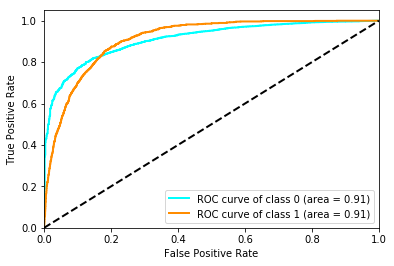

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.931328     0.594351     0.762840     0.882541      0.886955
precision     0.945813     0.545045     0.745429     0.882541      0.893039
recall        0.917281     0.653465     0.785373     0.882541      0.882541
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.911180     0.911180     0.911336     0.960730           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_209 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_210 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_75 (Batc (None, 256)               1024      
_________________________________________________________________
activation_75 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)         

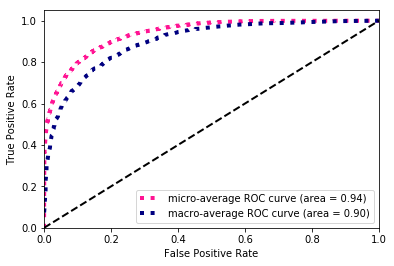

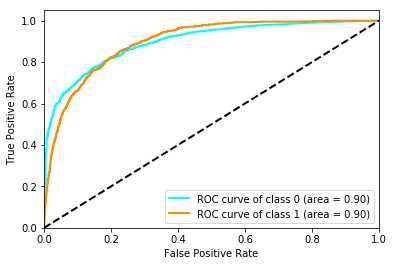

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.911826     0.565202     0.738514     0.853384      0.866181
precision     0.954200     0.463668     0.708934     0.853384      0.889605
recall        0.873055     0.723672     0.798364     0.853384      0.853384
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.897946     0.897946     0.898116     0.938156           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_214 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256)               1024      
_________________________________________________________________
activation_77 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)         

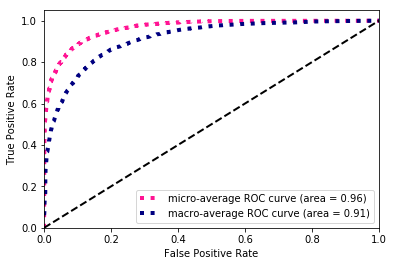

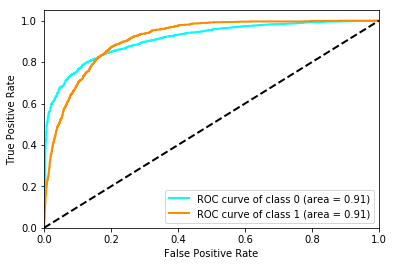

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.938332     0.577674     0.758003     0.892379      0.890840
precision     0.933766     0.597690     0.765728     0.892379      0.889511
recall        0.942943     0.558956     0.750949     0.892379      0.892379
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.911566     0.911566     0.911719     0.963828           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_49 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

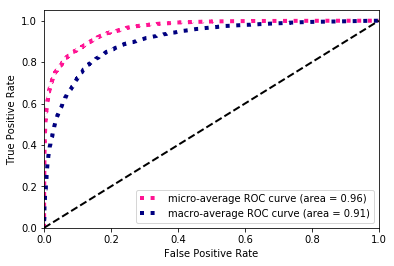

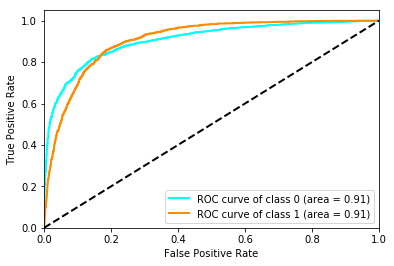

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.930094     0.583677     0.756885     0.880289      0.884477
precision     0.943415     0.538403     0.740909     0.880289      0.890082
recall        0.917144     0.637264     0.777204     0.880289      0.880289
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.906249     0.906250     0.906415     0.960067           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_51 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

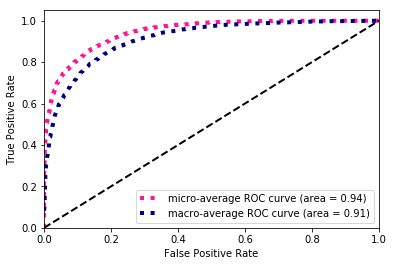

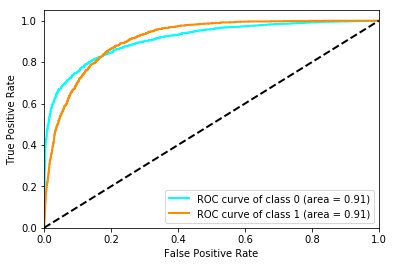

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.916096     0.588523     0.752310     0.860614      0.872961
precision     0.959641     0.481397     0.720519     0.860614      0.896665
recall        0.876331     0.756976     0.816653     0.860614      0.860614
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.911692     0.911692     0.911851     0.944034           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_53 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

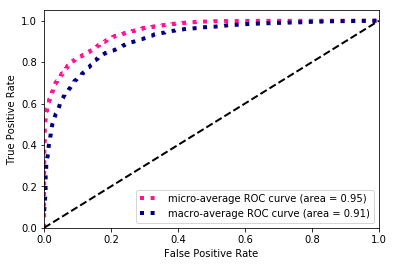

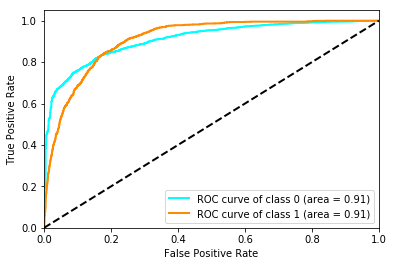

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.914094     0.576747     0.745421     0.857177      0.869672
precision     0.956723     0.472926     0.714825     0.857177      0.893016
recall        0.875102     0.738974     0.807038     0.857177      0.857177
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.909687     0.909687     0.909850     0.948700           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

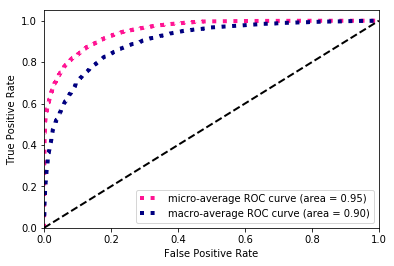

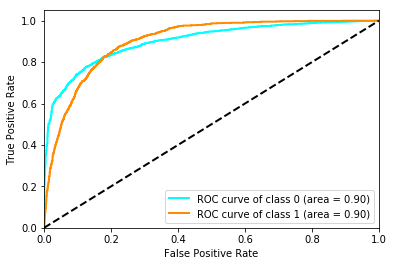

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.925125     0.575494     0.750310     0.872704      0.879085
precision     0.945426     0.513037     0.729232     0.872704      0.888488
recall        0.905678     0.655266     0.780472     0.872704      0.872704
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.901277     0.901277     0.901439     0.952839           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

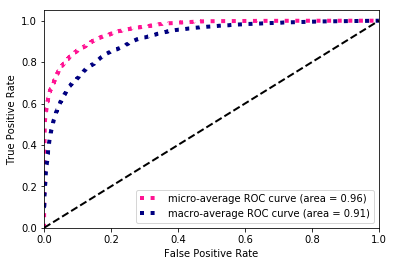

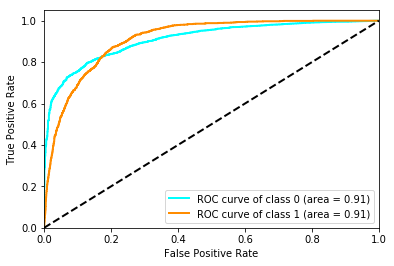

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.927706     0.587440     0.757573     0.876970      0.882899
precision     0.947099     0.525979     0.736539     0.876970      0.891645
recall        0.909091     0.665167     0.787129     0.876970      0.876970
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.910488     0.910488     0.910641     0.957756           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

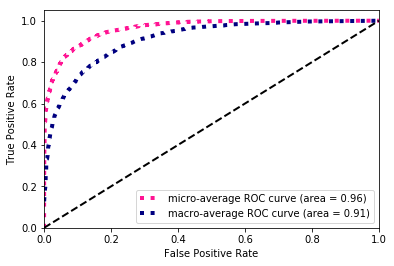

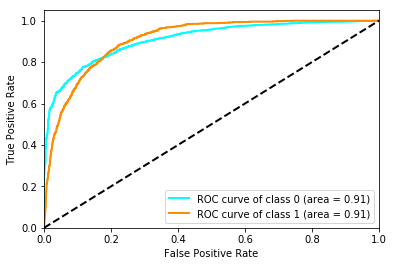

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.934378     0.588539     0.761459     0.886808      0.888837
precision     0.940778     0.564463     0.752620     0.886808      0.891224
recall        0.928064     0.614761     0.771413     0.886808      0.886808
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.910038     0.910038     0.910196     0.962301           NaN

In [21]:
Houston =compare_models('Houston',w=[1,1])

In [22]:
Houston

DNN       RNN  RNN_embed
0_f1-score              0.927162  0.920095   0.929070
1_f1-score              0.579076  0.582983   0.583825
weighted avg_f1-score   0.881325  0.875703   0.883607
micro avg_f1-score      0.876101  0.866027   0.878827
macro avg_f1-score      0.753119  0.751539   0.756447
0_precision             0.944593  0.953260   0.944434
1_precision             0.535468  0.497575   0.534493
weighted avg_precision  0.890718  0.893254   0.890452
micro avg_precision     0.876101  0.866027   0.878827
macro avg_precision     0.740030  0.725417   0.739464
0_recall                0.911093  0.889526   0.914278
1_recall                0.645365  0.711071   0.645065
weighted avg_recall     0.876101  0.866027   0.878827
micro avg_recall        0.876101  0.866027   0.878827
macro avg_recall        0.778229  0.800298   0.779671
0_auc                   0.906897  0.909209   0.907267
1_auc                   0.906897  0.909210   0.907268
micro avg_auc           0.954238  0.950933   0.957632
macro avg_auc           0.907057  0.909372   0.907426

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_256 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_257 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_91 (Batc (None, 256)               1024      
_________________________________________________________________
activation_91 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)         

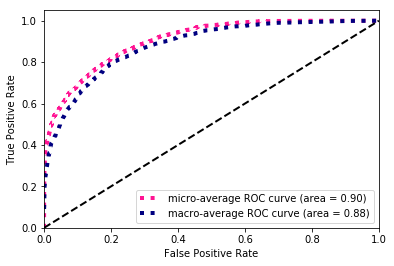

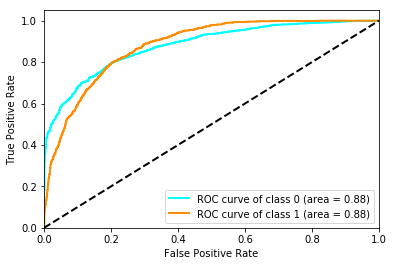

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.869632    0.627365     0.748498     0.806842      0.817753
precision     0.925926    0.534483     0.730204     0.806842      0.842103
recall        0.819791    0.759318     0.789555     0.806842      0.806842
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.880458    0.880458     0.880709     0.904772           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_260 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_261 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_93 (Batc (None, 256)               1024      
_________________________________________________________________
activation_93 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)         

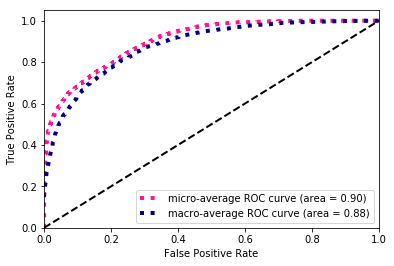

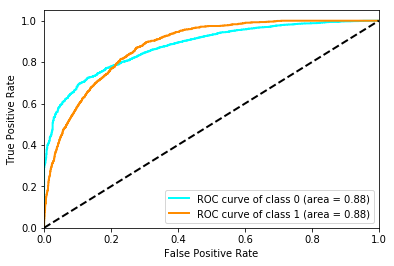

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.861296    0.610508     0.735902     0.795439      0.807592
precision     0.921880    0.515396     0.718638     0.795439      0.834836
recall        0.808183    0.748669     0.778426     0.795439      0.795439
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.877619    0.877619     0.877866     0.903374           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_265 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_95 (Batc (None, 256)               1024      
_________________________________________________________________
activation_95 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)         

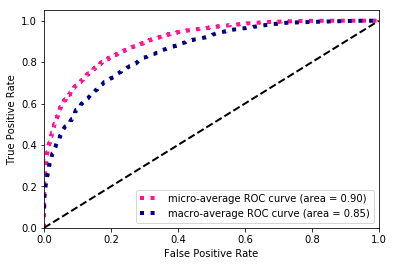

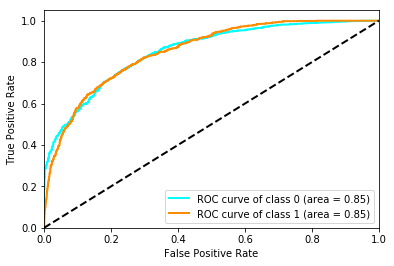

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.877308    0.598832     0.738070     0.812087      0.817675
precision     0.900917    0.551570     0.726243     0.812087      0.826108
recall        0.854904    0.654952     0.754928     0.812087      0.812087
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.852398    0.852398     0.852670     0.901833           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_61 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

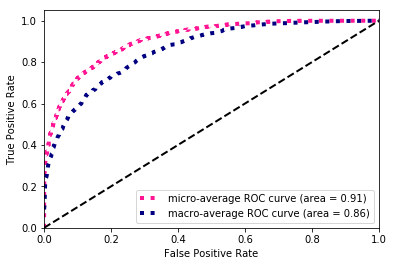

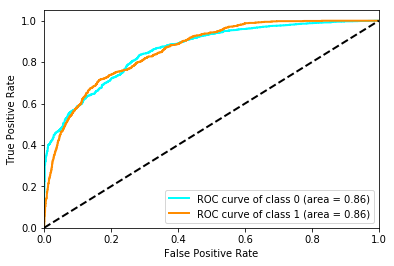

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.883534    0.617489     0.750512     0.821437      0.826563
precision     0.906317    0.570397     0.738357     0.821437      0.834383
recall        0.861869    0.673056     0.767463     0.821437      0.821437
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.859068    0.859068     0.859337     0.908984           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_63 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

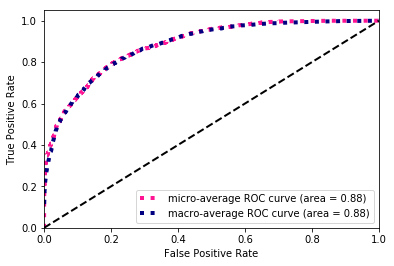

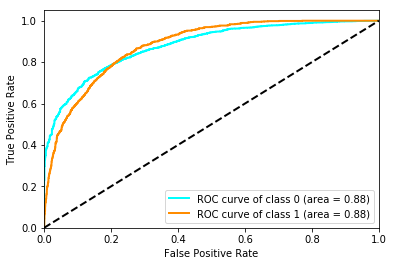

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.859241    0.619671     0.739456     0.794527      0.807939
precision     0.930626    0.513287     0.721956     0.794527      0.841257
recall        0.798027    0.781683     0.789855     0.794527      0.794527
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.880272    0.880272     0.880532     0.883752           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_65 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

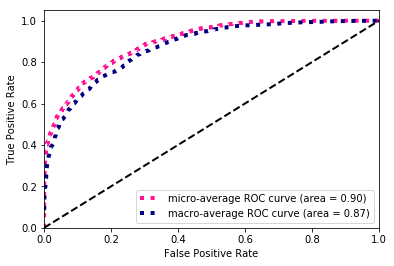

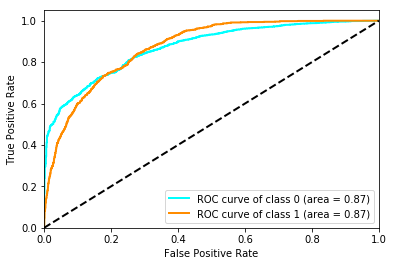

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.862691    0.609382     0.736036     0.796807      0.808447
precision     0.919816    0.517884     0.718850     0.796807      0.833747
recall        0.812246    0.740149     0.776198     0.796807      0.796807
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.871909    0.871909     0.872150     0.895220           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

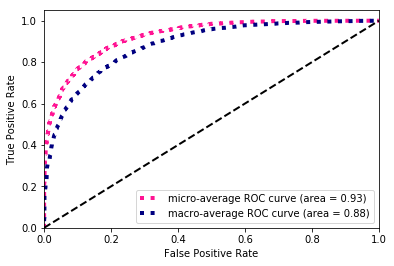

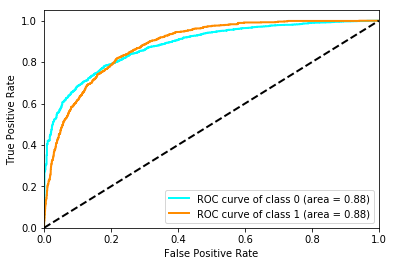

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.896952    0.622340     0.759646     0.838084      0.838147
precision     0.897213    0.621679     0.759446     0.838084      0.838210
recall        0.896692    0.623003     0.759848     0.838084      0.838084
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.883126    0.883126     0.883391     0.926126           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 33/60
 - 3s - loss: 0.3271 - f1_score: 0.6276 - val_loss: 0.2946 - val_f1_score: 0.1773
Epoch 34/60
 - 3s - loss: 0.3265 - f1_score: 0.6411 - val_loss: 0.2934 - val_f1_score: 0.3733
Epoch 35/60
 - 3s - loss: 0.3264 - f1_score: 0.6350 - val_loss: 0.3056 - val_f1_score: 0.4090
Epoch 36/60
 - 3s - loss: 0.3266 - f1_score: 0.6205 - val_loss: 0.3188 - val_f1_score: 0.4353
Epoch 37/60
 - 3s - loss: 0.3262 - f1_score: 0.6290 - val_loss: 0.3150 - val_f1_score: 0.4074
Epoch 38/60
 - 3s - loss: 0.3279 - f1_score: 0.6319 - val_loss: 0.3167 - val_f1_score: 0.3988
Epoch 39/60
 - 3s - loss: 0.3255 - f1_score: 0.6346 - val_loss: 0.3180 - val_f1_score: 0.2145
Epoch 40/60
 - 3s - loss: 0.3251 - f1_score: 0.6280 - val_loss: 0.3028 - val_f1_score: 0.3836
Epoch 41/60
 - 3s - loss: 0.3234 - f1_score: 0.6390 - val_loss: 0.3074 - val_f1_score: 0.3849
Epoch 42/60
 - 3s - loss: 0.3247 - f1_score: 0.6324 - val_loss: 0.3050 - val_f1_score: 0.3708
Epoch 43/60
 - 3s - loss: 0.3241 - f1_score: 0.6302 - val_lo

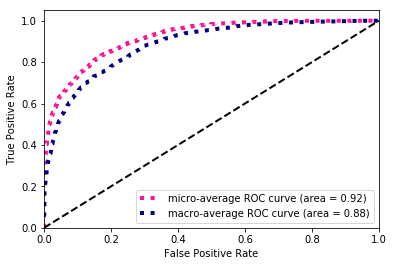

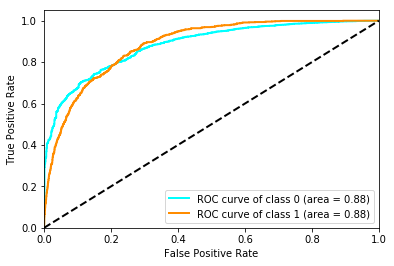

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.888922    0.638875     0.763899     0.830103      0.835377
precision     0.914137    0.586299     0.750218     0.830103      0.843934
recall        0.865061    0.701810     0.783436     0.830103      0.830103
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.883388    0.883388     0.883642     0.919084           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

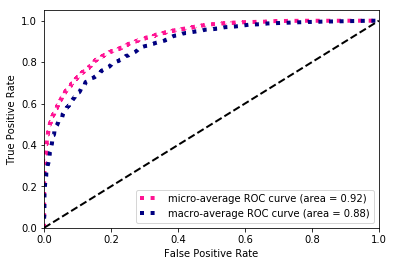

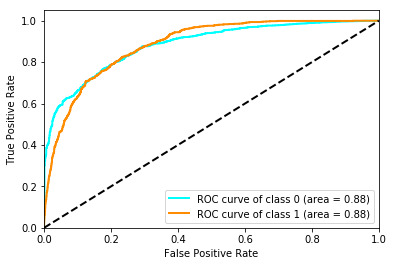

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.886152    0.641098     0.763625     0.827138      0.833676
precision     0.918431    0.577153     0.747792     0.827138      0.845350
recall        0.856065    0.720980     0.788522     0.827138      0.827138
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.883998    0.883998     0.884256     0.916172           NaN

In [23]:
Charlotte = compare_models('Charlotte',w=[1,1])

In [ ]:
Charlotte

DNN       RNN  RNN_embed
0_f1-score              0.869412  0.868489   0.890675
1_f1-score              0.612235  0.615514   0.634105
weighted avg_f1-score   0.814340  0.814317   0.835734
micro avg_f1-score      0.804789  0.804257   0.831775
macro avg_f1-score      0.740823  0.742001   0.762390
0_precision             0.916241  0.918920   0.909927
1_precision             0.533816  0.533856   0.595044
weighted avg_precision  0.834349  0.836462   0.842498
micro avg_precision     0.804789  0.804257   0.831775
macro avg_precision     0.725029  0.726388   0.752485
0_recall                0.827626  0.824047   0.872606
1_recall                0.720980  0.731629   0.681931
weighted avg_recall     0.804789  0.804257   0.831775
micro avg_recall        0.804789  0.804257   0.831775
macro avg_recall        0.774303  0.777838   0.777269
0_auc                   0.870159  0.870416   0.883504
1_auc                   0.870159  0.870416   0.883504
micro avg_auc           0.903326  0.895985   0.920460
macro avg_auc           0.870415  0.870673   0.883763

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)         

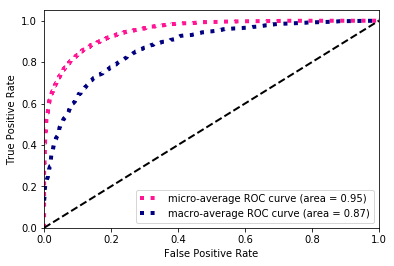

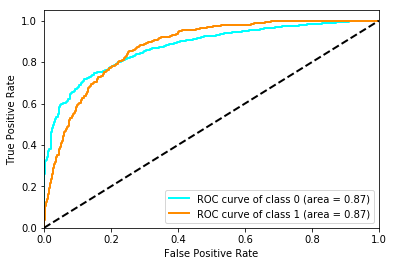

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.924780    0.494220     0.709500     0.869036      0.874675
precision     0.938905    0.448819     0.693862     0.869036      0.881873
recall        0.911073    0.549839     0.730456     0.869036      0.869036
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.874375    0.874375     0.874660     0.950103           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)         

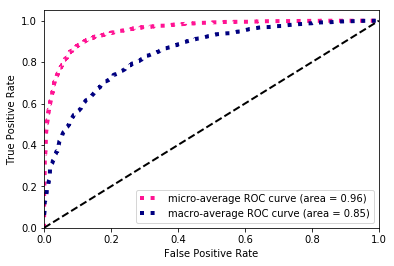

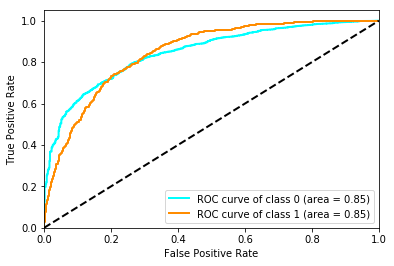

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.940807    0.291262     0.616034     0.890739      0.865219
precision     0.902392    0.594059     0.748226     0.890739      0.866511
recall        0.982638    0.192926     0.587782     0.890739      0.890739
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.846626    0.846626     0.846942     0.955329           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)         

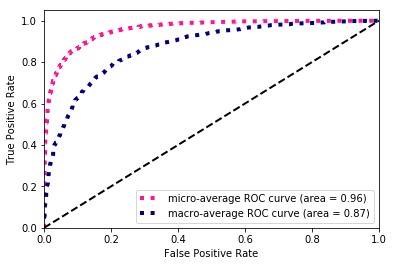

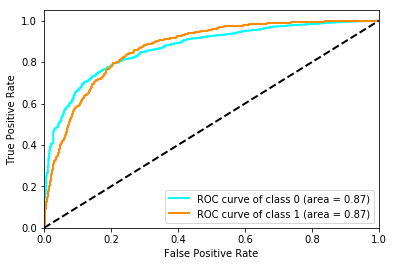

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.936548    0.451264     0.693906     0.886249      0.880075
precision     0.923441    0.514403     0.718922     0.886249      0.875841
recall        0.950032    0.401929     0.675981     0.886249      0.886249
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.868880    0.868880     0.869181     0.957962           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

Epoch 42/60
 - 4s - loss: 0.2599 - f1_score: 0.3639 - val_loss: 0.0655 - val_f1_score: 0.0000e+00
Epoch 43/60
 - 4s - loss: 0.2613 - f1_score: 0.3466 - val_loss: 0.0624 - val_f1_score: 0.0000e+00
Epoch 44/60
 - 4s - loss: 0.2599 - f1_score: 0.3673 - val_loss: 0.0644 - val_f1_score: 0.0000e+00
Epoch 45/60
 - 4s - loss: 0.2612 - f1_score: 0.3605 - val_loss: 0.0940 - val_f1_score: 0.0000e+00
Epoch 46/60
 - 4s - loss: 0.2608 - f1_score: 0.3671 - val_loss: 0.0856 - val_f1_score: 0.1132
Epoch 47/60
 - 4s - loss: 0.2606 - f1_score: 0.3509 - val_loss: 0.0955 - val_f1_score: 0.0952


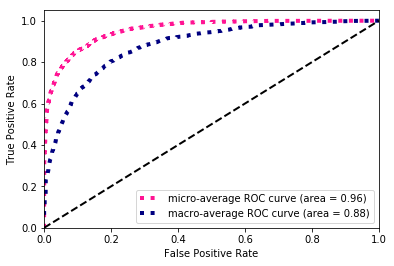

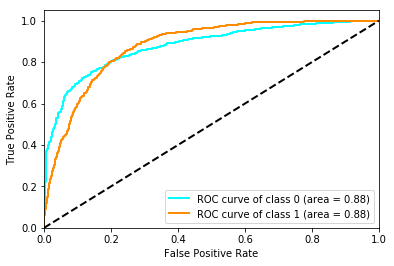

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.929027    0.477308     0.703168     0.875023      0.876460
precision     0.932395    0.464939     0.698667     0.875023      0.877997
recall        0.925683    0.490354     0.708018     0.875023      0.875023
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.879101    0.879101     0.879417     0.955025           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

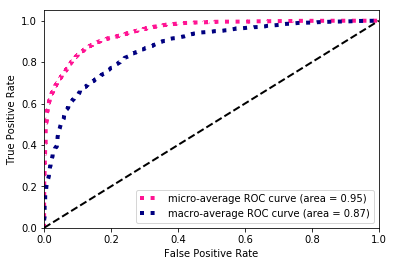

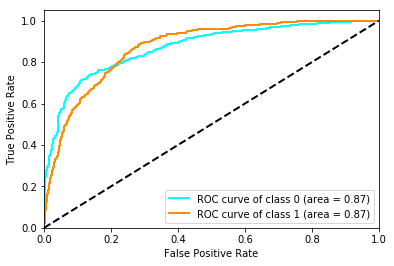

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.925547    0.509581     0.717564     0.870720      0.877141
precision     0.942299    0.456163     0.699231     0.870720      0.885727
recall        0.909380    0.577170     0.743275     0.870720      0.870720
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.872623    0.872623     0.872926     0.948187           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


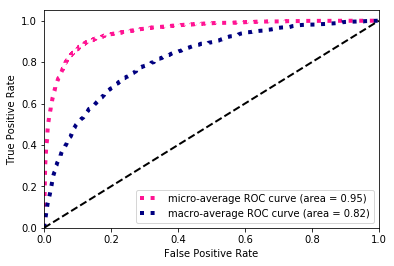

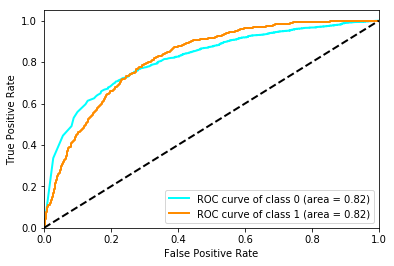

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.815663    0.818322     0.817264     0.948821           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

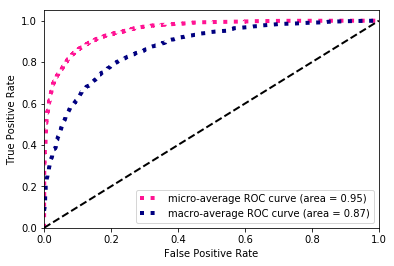

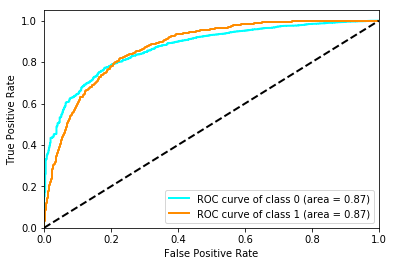

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.932442    0.494845     0.713644     0.880823      0.881519
precision     0.934127    0.488263     0.711195     0.880823      0.882241
recall        0.930764    0.501608     0.716186     0.880823      0.880823
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.871471    0.871471     0.871765     0.954613           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

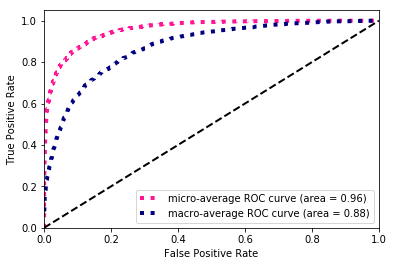

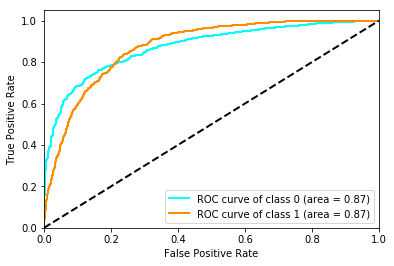

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.934454    0.466667     0.700560     0.883255      0.880017
precision     0.927246    0.498175     0.712711     0.883255      0.877315
recall        0.941774    0.438907     0.690341     0.883255      0.883255
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.874729    0.874729     0.875015     0.958047           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

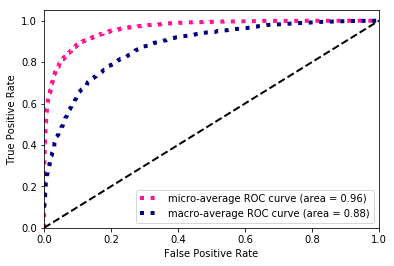

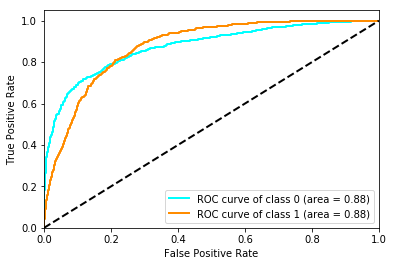

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.940598    0.373650     0.657124     0.891487      0.874622
precision     0.910930    0.569079     0.740005     0.891487      0.871149
recall        0.972263    0.278135     0.625199     0.891487      0.891487
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.875313    0.875313     0.875613     0.961410           NaN

In [12]:
Dallas = compare_models('Dallas',w=[1,1])

In [13]:
Dallas

DNN       RNN  RNN_embed
0_f1-score              0.934045  0.930931   0.935831
1_f1-score              0.412248  0.328963   0.445054
weighted avg_f1-score   0.873323  0.860880   0.878719
micro avg_f1-score      0.882008  0.876458   0.885189
macro avg_f1-score      0.673147  0.629947   0.690443
0_precision             0.921579  0.919441   0.924101
1_precision             0.519094  0.307034   0.518506
weighted avg_precision  0.874742  0.848175   0.876902
micro avg_precision     0.882008  0.876458   0.885189
macro avg_precision     0.720336  0.613238   0.721303
0_recall                0.947914  0.945021   0.948267
1_recall                0.381565  0.355841   0.406217
weighted avg_recall     0.882008  0.876458   0.885189
micro avg_recall        0.882008  0.876458   0.885189
macro avg_recall        0.664740  0.650431   0.677242
0_auc                   0.863294  0.855795   0.873838
1_auc                   0.863294  0.856682   0.873838
micro avg_auc           0.954465  0.950678   0.958024
macro avg_auc           0.863594  0.856536   0.874131